Process till parameter optimization of both Vasicek and CIR models are same except when modelling future rates, (square root(r(t))) is multiplied in stochastic part of CIR model

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader.data as web
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize

In [2]:
#Extracting 3 month interest rates of past 1 year
ir = web.DataReader('DGS3MO', 'fred', '2024-05-24', '2025-05-24')
ir['r(t) (*100%)']=ir['DGS3MO']/100     #Converting % to float
ir=ir.bfill()
del ir['DGS3MO']
ir['dr(t)']=ir['r(t) (*100%)']-ir['r(t) (*100%)'].shift(1)      #Change in interest rates
ir=ir[1:]
ir.head()

,r(t) (*100%),dr(t)
DATE,,
2024-05-27,0.0546,0.0
2024-05-28,0.0546,0.0
2024-05-29,0.0546,0.0
2024-05-30,0.0546,0.0
2024-05-31,0.0546,0.0


CIR Model: dr(t)=a(b-r(t))*dt + stdev*(square root(r(t)))*(dW(t))

In [11]:
#Initial Estimation of Parameters
dt=1/252    #Daily Time Interval
r=np.array(ir['r(t) (*100%)'])
delta_r=np.array(ir['dr(t)'][1:])
r_lag = r[:-1]  

X = r_lag.reshape(-1, 1)
y = delta_r
reg = LinearRegression().fit(X, y)
alpha = reg.intercept_
beta = reg.coef_[0]

# Initial guesses
a_init = -beta / dt
b_init = alpha / (a_init * dt)
residuals = y - reg.predict(X)
sigma_init = np.std(residuals) / np.sqrt(dt)
print(a_init,b_init,sigma_init)

1.1832603239794766 0.03839619123491157 0.0033004125453000555


In [18]:
ir['dr(t) (Model)']=a_init*(b_init-ir['r(t) (*100%)'])*dt
ir['Actual-Model']=ir['dr(t)']-ir['dr(t) (Model)']      #Actual-Model values
ir['PDF (Actual-Model)']=norm.pdf(ir['Actual-Model'], loc=0, scale=sigma_init)   #PDF of Actual-Model values
ir['ln(PDF)']=np.log(ir['PDF (Actual-Model)'])
sum_=ir['ln(PDF)'].sum()
ir.head()

,r(t) (*100%),dr(t),dr(t) (Model),Actual-Model,PDF (Actual-Model),ln(PDF)
DATE,,,,,,
2024-05-27,0.0546,0.0,-0.000076,0.000076,120.844374,4.794504
2024-05-28,0.0546,0.0,-0.000076,0.000076,120.844374,4.794504
2024-05-29,0.0546,0.0,-0.000076,0.000076,120.844374,4.794504
2024-05-30,0.0546,0.0,-0.000076,0.000076,120.844374,4.794504
2024-05-31,0.0546,0.0,-0.000076,0.000076,120.844374,4.794504


In [15]:
#Optimization
def log_likelihood_wrapper(params):
    a, b, sigma = params
    if a <= 0 or sigma <= 0:
        return np.inf  # to keep optimizer in valid range

    dr_model = a * (b - r[:-1]) * dt
    residuals = r[1:] - r[:-1] - dr_model
    var = sigma**2 * dt
    log_pdf = -0.5 * np.log(2 * np.pi * var) - (residuals ** 2) / (2 * var)
    return -np.sum(log_pdf)  # return negative log-likelihood

initial_guess = [a_init, b_init, sigma_init]
res = minimize(log_likelihood_wrapper, initial_guess, bounds=[(1e-5, None)]*3)
a_est, b_est, sigma_est = res.x

print(f"Estimated a = {a_est:.6f}")
print(f"Estimated b = {b_est:.6f}")
print(f"Estimated sigma = {sigma_est:.6f}")

Estimated a = 1.183260
Estimated b = 0.038396
Estimated sigma = 0.003300


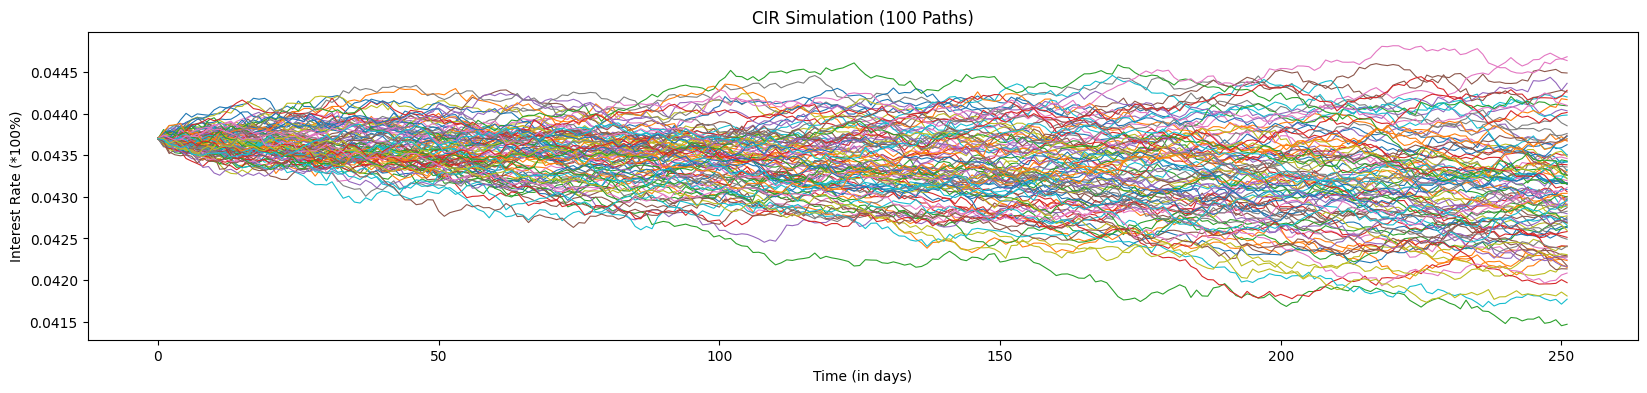

In [21]:
#Modelling interest rates for 1 year ahead
current_rate=ir['r(t) (*100%)'].iloc[-1]
simulations=100
sim=[]
np.random.seed(0)
for i in range(simulations):
    sim.append([current_rate])
for i in range(simulations):
    for j in range(1,252):    #252 trading days in a year
        sim[i].append(((a_est/10)*(b_est-sim[i][j-1])*dt + sigma_est*(dt**0.5)*((sim[i][j-1]**0.5))*np.random.normal(loc=0,scale=1))+sim[i][j-1])
#Plotting the results
plt.figure(figsize=(20,4))
for path in sim:
    plt.plot(path, linewidth=0.8) 
plt.title("CIR Simulation (100 Paths)")
plt.xlabel("Time (in days)")
plt.ylabel("Interest Rate (*100%)")
plt.show()